# Learning Curve Analysis 

cf. Hanne, A.A., Tünnermann, J. & Schubö, A. Target templates and the time course of distractor location learning. Sci Rep 13, 1672 (2023). https://doi.org/10.1038/s41598-022-25816-9

This notebook provides the code for fitting a learning curve of the form

$ RT(x) = a+(s-a) \cdot (x)^{-c}$

where RT is the predicted response time at block $x$, $a$ is the asymptotic RT-level at which the slope of the curve approaches zero, $s$ is the starting RT level (RT level observers have before they start learning) and $c$ is a decrease rate parameter that models how quickly the asymptote is approached.

Due to the stochastic nature of MCMC sampling, the results depicted in this notebook might differ slightly numerically from the values reported in the paper.

This notebook can sample the traces (this takes long) or load them from disk. You can download our traces from **TODO** and copy them in the traces/ subfolder.

### Imports:

In [1]:
import pandas as pd
import seaborn as sns
import pymc as pm
import aesara.tensor as at
import arviz as az
%matplotlib notebook
from matplotlib.pylab import plt
import os.path
import numpy as np
from numpy import mean


# Colors for visualizations:
palette = {'learning' : ["#a6cee3", "#1f78b4"],
           'search' :  ["#b2df8a", "#33a02c", "#999999"]} 

### Select experimental task
Decide which experimental task (learning or search task) you would like to load for fitting the learning curve.

In [2]:
#experiment = 'learning' 
experiment = 'search'
group = 'tool_vehicle_group'
#group = 'fruit_vegetable_group'

### Load data

In [3]:
data = pd.read_csv('data/Dataset_Learning_Curve_Model.csv')
data = data[data['task'] == experiment]
data = data[data['group'] == group]

display(data)

Unnamed: 0  participant_number  block_number  \
40214       40214                   1             0   
40215       40215                   1             0   
40216       40216                   1             0   
40217       40217                   1             0   
40218       40218                   1             0   
...           ...                 ...           ...   
54834       54834                  50             3   
54835       54835                  50             3   
54836       54836                  50             3   
54837       54837                  50             3   
54838       54838                  50             3   

                       condition      RT               group    task  
40214          distractor_absent   675.0  tool_vehicle_group  search  
40215  nonpredictive_distractors   718.0  tool_vehicle_group  search  
40216     predictive_distractors  1045.0  tool_vehicle_group  search  
40217          distractor_absent   629.0  tool_vehicle_group  search  
40218     predictive_distractors   713.0  tool_vehicle_group  search  
...                          ...     ...                 ...     ...  
54834     predictive_distractors   544.9  tool_vehicle_group  search  
54835  nonpredictive_distractors   712.0  tool_vehicle_group  search  
54836          distractor_absent   585.0  tool_vehicle_group  search  
54837  nonpredictive_distractors   392.4  tool_vehicle_group  search  
54838  nonpredictive_distractors   465.4  tool_vehicle_group  search  

[14625 rows x 7 columns]

### Data preprocessing

Define arrays

In [4]:
block_number = data['block_number'].values+1 # since the block number starts with 0
participant_idx, participants  = pd.factorize(data['participant_number'])
conditions = ['distractor_absent', 'nonpredictive_distractors', 'predictive_distractors']
condition_idx = [conditions.index(e) for e in data['condition']]
n_participant_idx = len(participants)
n_condition_idx = len(conditions)

Convert response times to seconds

In [5]:
RTS = data['RT']  / 1000.0

### Define the learning curve

In [6]:
def learning_curve(s, a, x, c):
    return (a + (s - a) * (x) ** (-c))

### Define the models

The function below can return the learing curve model allowing for condition-dependent effects in $a$, $c$, or both.

In [7]:
with pm.Model() as model:

    s_mu = pm.Normal('s_mu', 1.8, 1, shape=n_condition_idx)
    s_eff_σ_dist =  pm.HalfCauchy.dist(1, shape=n_condition_idx) 
    s_col, _, s_sd = pm.LKJCholeskyCov('s_col_cov', n=n_condition_idx, eta=1, sd_dist=s_eff_σ_dist, compute_corr=True)
    s_effs_raw = pm.Normal('s_effect_raw', mu=0, sigma=1, shape=(n_participant_idx,n_condition_idx))
    s_effs = pm.Deterministic('s_effs', at.dot(s_col, s_effs_raw.T).T)
    s = pm.Deterministic('s', pm.math.exp(s_mu + s_effs))

    sd_mu = pm.Normal('sd_mu', -2, 1)
    sd_sd = pm.HalfCauchy('sd_sd', 0.1)
    sd_z = pm.Normal('sd_e', 0, 1, shape=n_participant_idx)

    sd = pm.Deterministic('sd', pm.math.exp(sd_mu + sd_z * sd_sd))


    c_mu = pm.Normal('c_mu', 1.8, 1.8, shape=n_condition_idx)
    c_eff_σ_dist =  pm.HalfCauchy.dist(0.5, shape=n_condition_idx) 
    c_col, _, c_sd = pm.LKJCholeskyCov('c_col_cov', n=n_condition_idx, eta=1, sd_dist=c_eff_σ_dist, compute_corr=True)
    c_effs_raw = pm.Normal('c_effect_raw', mu=0, sigma=1, shape=(n_participant_idx,n_condition_idx))
    c_effs = pm.Deterministic('c_effs', at.dot(c_col, c_effs_raw.T).T)
    c = pm.Deterministic('c', pm.math.exp(c_mu + c_effs))

    a_mu = pm.Normal('a_mu',  -0.5, 0.5, shape=n_condition_idx)
    a_eff_σ_dist = pm.HalfCauchy.dist(1, shape=n_condition_idx)
    a_col, _, a_sd = pm.LKJCholeskyCov('a_col_cov', n=n_condition_idx, eta=1, sd_dist=a_eff_σ_dist, compute_corr=True)
    a_eff_raw = pm.Normal('a_effect_raw', mu=0, sigma=1, shape=(n_participant_idx,n_condition_idx))
    a_eff = pm.Deterministic('a_effect', at.dot(a_col, a_eff_raw.T).T)
    a = pm.Deterministic('a', pm.math.exp(a_mu + a_eff))

    idx = (participant_idx, condition_idx)

    a_group_mean = pm.Deterministic('a_group_mean', pm.math.exp(a_mu + (a_sd*a_sd) / 2.0))
    c_group_mean = pm.Deterministic('c_group_mean', pm.math.exp(c_mu + (c_sd*c_sd) / 2.0))
    s_group_mean = pm.Deterministic('s_group_mean', pm.math.exp(s_mu + (s_sd*s_sd) / 2.0))

    mean_in_block = pm.Deterministic('mean_in_block', learning_curve(s[idx], a[idx], block_number, c[idx]))

    obs = pm.Normal('obs', mu=mean_in_block, sigma=sd[participant_idx], observed=RTS) 

### Run the models (or load samples from disk)

The cell below runs the differerent model variants and saves the traces. Alternatively, if traces already exist, they are loaded from disk for further analysis

In [8]:
samples = 20000
tune = 2000
thin = 4

fn = 'traces/trace_'+group+'_'+experiment+'.nc'
if not os.path.isfile(fn):
    print('Fitting and storing '+group+'_'+experiment)
    trace = pm.sample(samples, model=model, tune=tune, target_accept=0.95, init='adapt_diag') # ta = 90
    trace = trace.sel(draw=slice(0, None, thin))
    trace.to_netcdf(fn)

else:
    print('Loading '+group+'_'+experiment+ ' from disk! Delete/rename the existing file if you want to fit newly instead of loading')
    trace = az.from_netcdf(fn)

Loading tool_vehicle_group_search from disk! Delete/rename the existing file if you want to fit newly instead of loading


### Convergence diagnostics

Run the cell below to visually assess convergence.

ATTENTION: Cell produces many plots

<IPython.core.display.Javascript object>


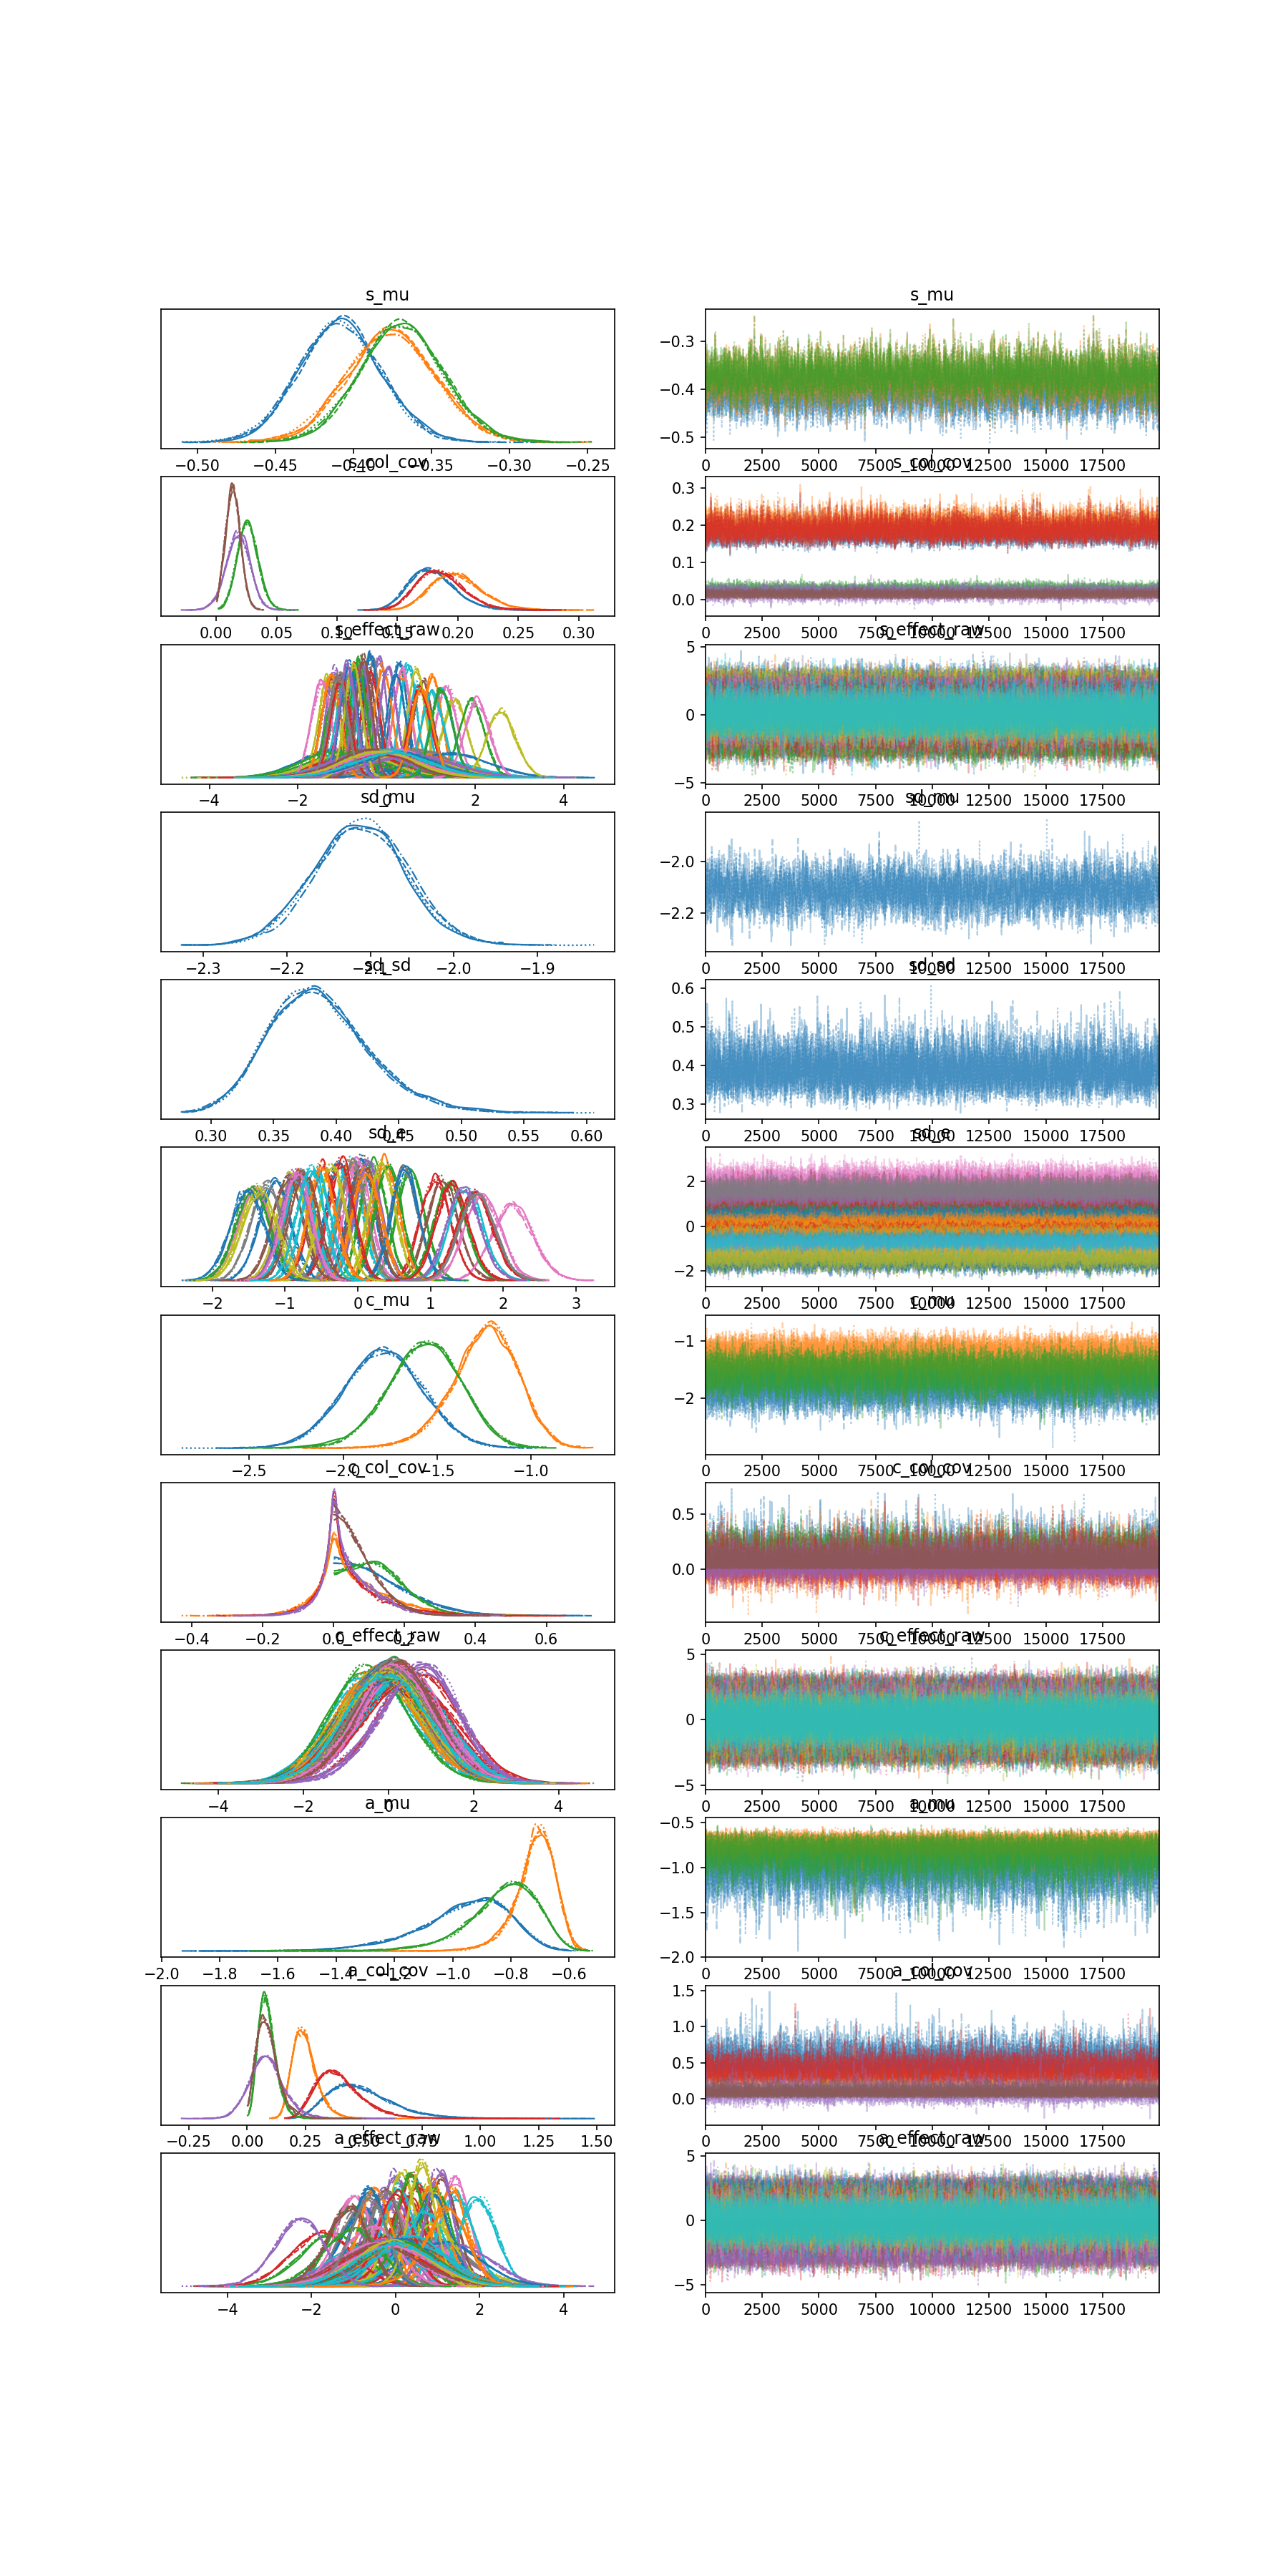

Parameter s: Correlation between 0 and 1:


<IPython.core.display.Javascript object>


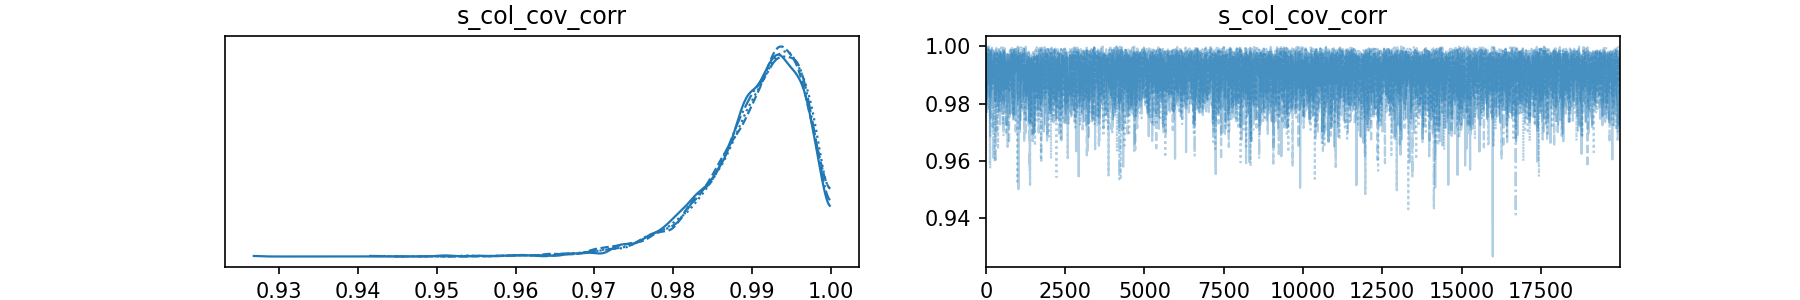

Parameter s: Correlation between 0 and 2:


<IPython.core.display.Javascript object>


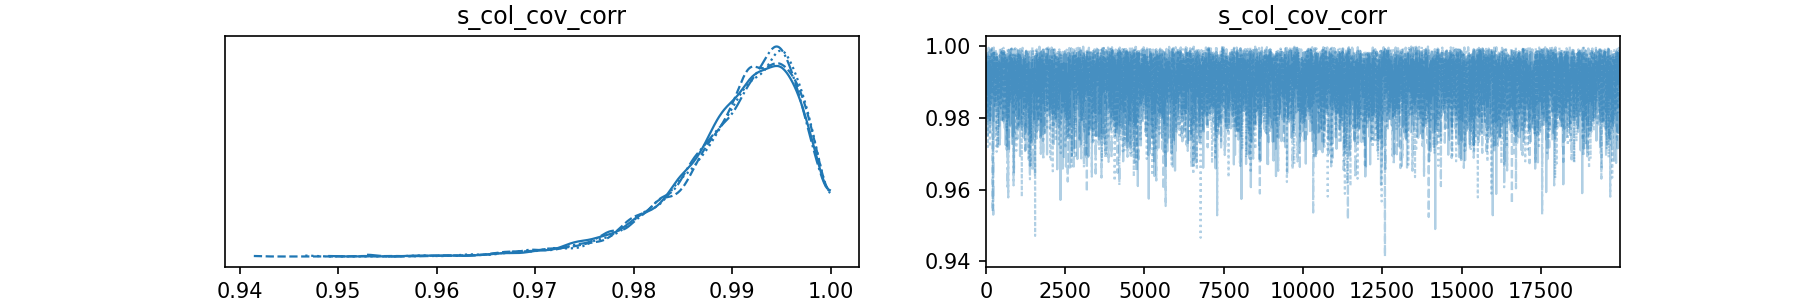

Parameter s: Correlation between 1 and 2:


<IPython.core.display.Javascript object>


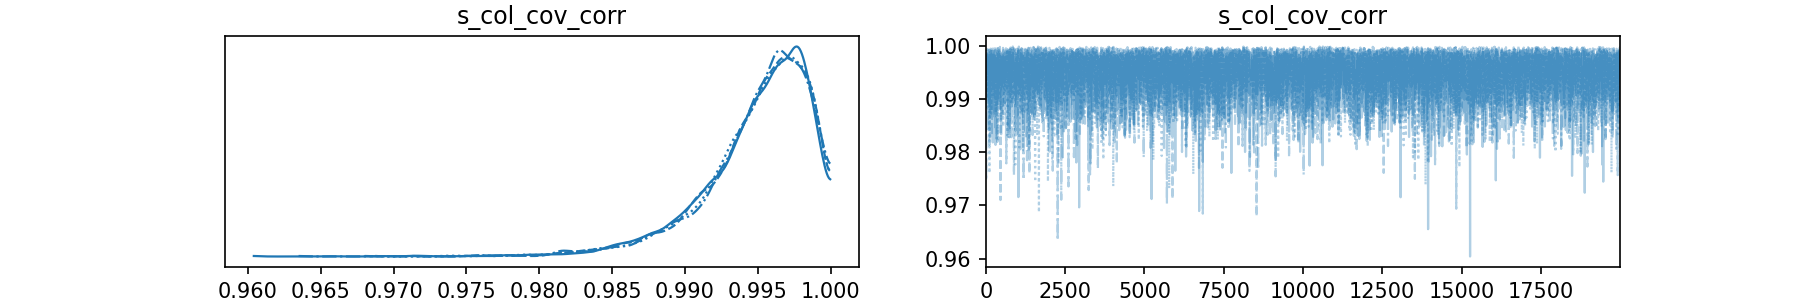

Parameter a: Correlation between 0 and 1:


<IPython.core.display.Javascript object>


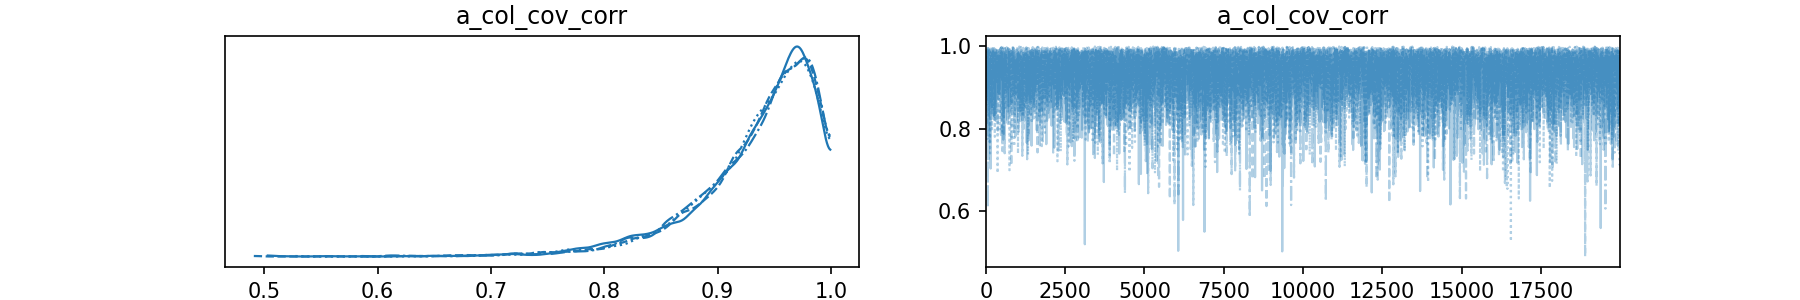

Parameter a: Correlation between 0 and 2:


<IPython.core.display.Javascript object>


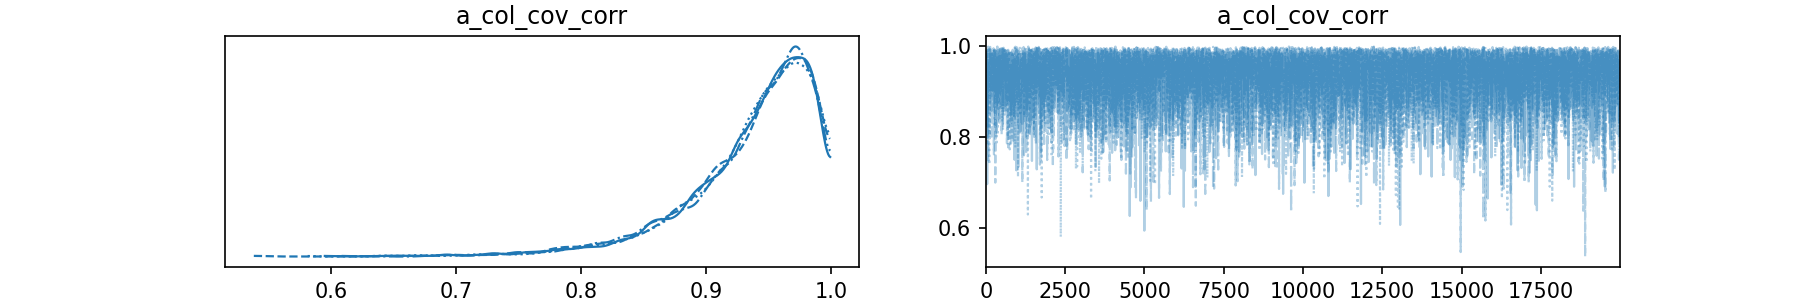

Parameter a: Correlation between 1 and 2:


<IPython.core.display.Javascript object>


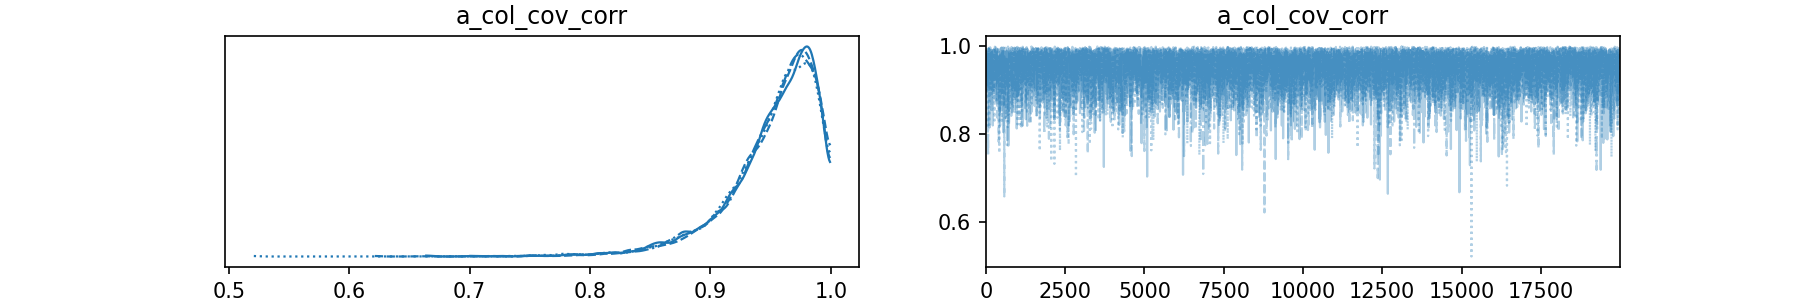

Parameter c: Correlation between 0 and 1:


<IPython.core.display.Javascript object>


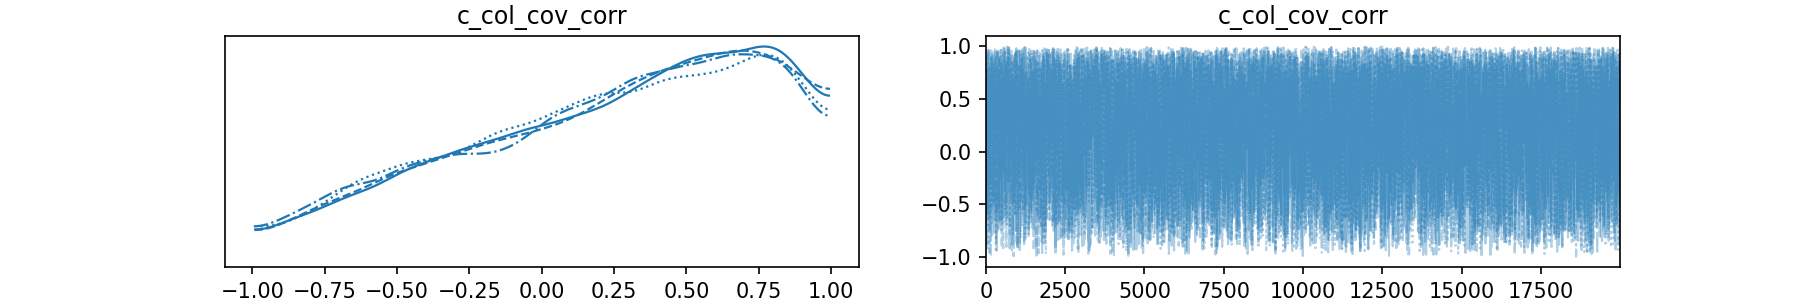

Parameter c: Correlation between 0 and 2:


<IPython.core.display.Javascript object>


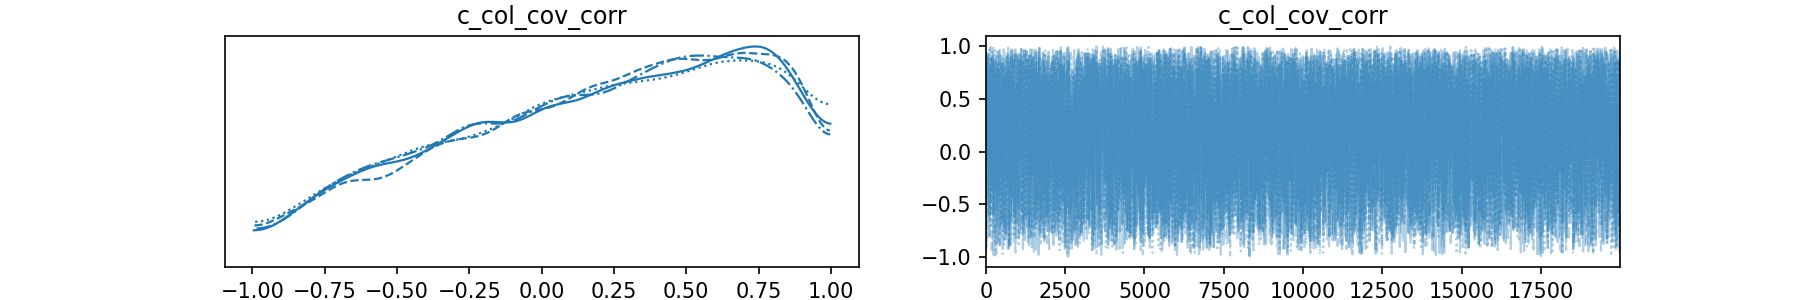

Parameter c: Correlation between 1 and 2:


<IPython.core.display.Javascript object>


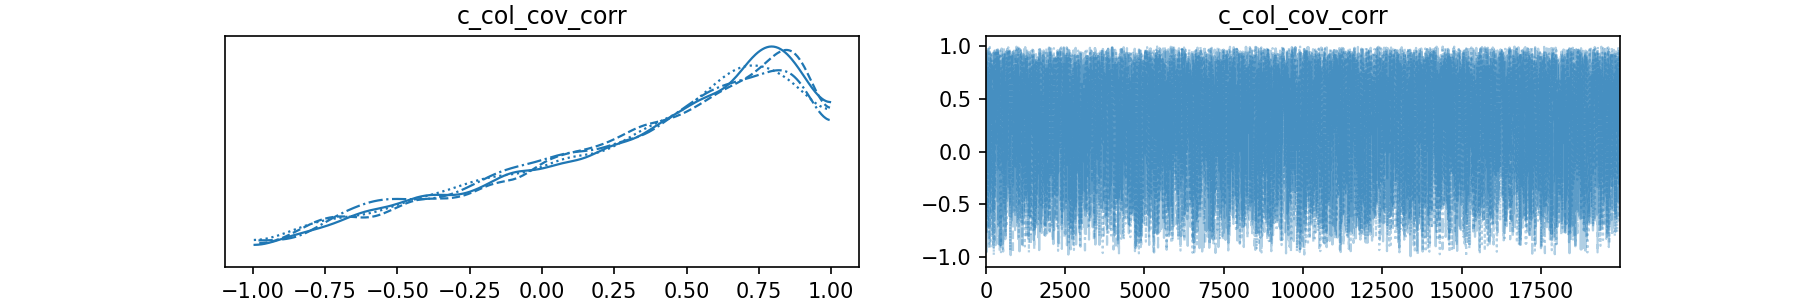

In [9]:
# Plot traces except the LKJCholeskyCov correlation variables, which do not work directly with plot_trace
#trace = az.from_netcdf('traces/trace_tool_vehicle_group_search.nc')
#trace = az.from_netcdf('traces/trace_fruit_vegetable_group_search.nc')

az.plot_trace(trace, var_names=[v.name for v in model.basic_RVs 
                                 if 'corr' not in v.name and v.name is not 'obs'])
for parameter in ['s','a','c']:
    for pair in [[0,1], [0,2], [1,2]]:
        print('Parameter %s: Correlation between %d and %d:'%(parameter, pair[0], pair[1]))
        az.plot_trace(trace, var_names=[parameter+'_col_cov_corr'] , 
                      coords ={parameter+'_col_cov_corr_dim_0' : pair[0],
                               parameter+'_col_cov_corr_dim_1' : pair[1]})


### Plot learning curves

Sample form the posterior predictive and create aggregated curves.
This may take a while

<IPython.core.display.Javascript object>


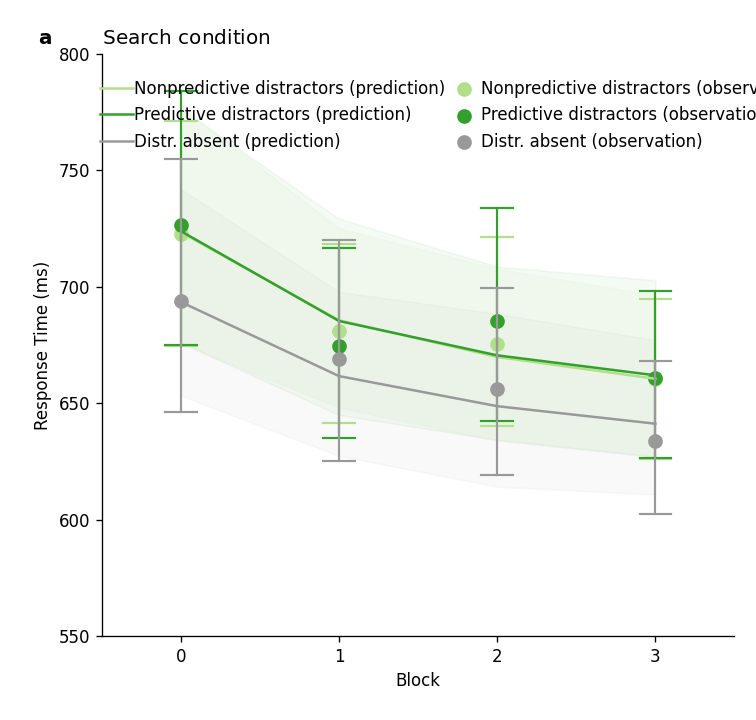

In [22]:
# Sample from the posterior predictive distribution

with model:
    ppc_samples = pm.sample_posterior_predictive(trace,keep_size=True)


data['prediction_mean'] =  mean(ppc_samples.posterior_predictive['obs'], axis=(0,1))*1000
data['condition_pred'] = data['condition'] + ' (prediction)'
data['condition_obs'] = data['condition'] + ' (observation)'
data['condition_pred'] = data['condition'] + ' (prediction)'

data_p = data.groupby(['participant_number', 'block_number', 'condition','condition_obs','condition_pred']).mean().reset_index()
data_p['RT_s'] = data_p['RT'] #/ 1000.0

fig, ax = plt.subplots(figsize=(5.25,5))
 
sns.set_palette(palette[experiment], 3)

# Rename columns for plotting:
data_p = data_p.rename(columns=
{
  'block_number'      : 'Block',
  'RT_s'              : 'Response Time (ms)'
})

# Rename values
data_p = data_p.replace({                       
  'nonpredictive_distractors (prediction)' : 'Nonpredictive distractors (prediction)',
  'predictive_distractors (prediction)'  : 'Predictive distractors (prediction)',
  'distractor_absent (prediction)' : 'Distr. absent (prediction)',
  'nonpredictive_distractors (observation)' : 'Nonpredictive distractors (observation)',
  'predictive_distractors (observation)'  : 'Predictive distractors (observation)',
  'distractor_absent (observation)' : 'Distr. absent (observation)'
})

# Plot
sns.lineplot(data=data_p, x='Block', y='prediction_mean', hue='condition_pred',
             hue_order=['Nonpredictive distractors (prediction)', 'Predictive distractors (prediction)', 'Distr. absent (prediction)'],
             ax=ax, err_kws={'alpha' : 0.05})
sns.pointplot(data=data_p, x='Block', y='Response Time (ms)', hue='condition_obs',
              hue_order=['Nonpredictive distractors (observation)', 'Predictive distractors (observation)', 'Distr. absent (observation)'],
              join=False, ax=ax, errwidth=1.3, capsize=0.2)
sns.despine()

plt.ylim(550, 800)
h,l = ax.get_legend_handles_labels()
ax.legend_.remove()

fig.legend(h,l, ncol=2, bbox_to_anchor=(0.6,0.84), loc='center', frameon=False, handletextpad=0.07, columnspacing=0.1)
plt.title(r'${\bf{a}}$        ' + experiment.capitalize() + ' condition', y=1 , x=-0.1, loc='left')
plt.tight_layout()
plt.savefig('figures/ post_pred_curves_' +group+'_'+ experiment + '.svg', dpi=150)

### Plot parameter estimates

The cell below plots the group-level estimates of the main parameters

<IPython.core.display.Javascript object>


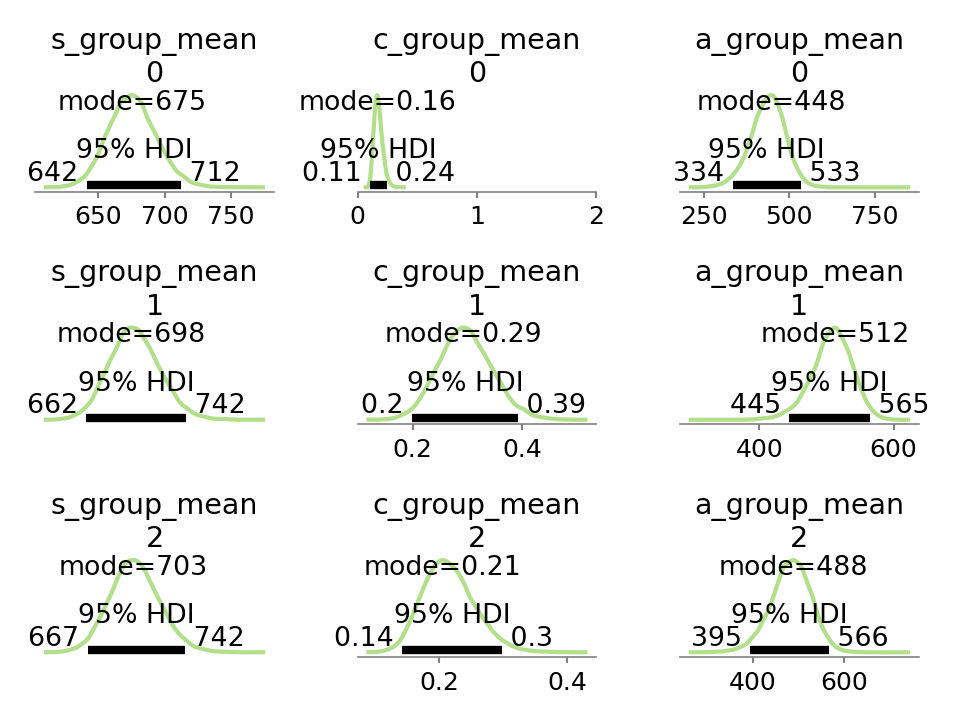

In [11]:
f, ax = plt.subplots(3,3)#, sharex='col')
with model: 
    az.plot_posterior(trace, var_names=["s_group_mean"],transform=lambda x: x*1000,
                    hdi_prob=0.95, show=True, ax=ax[:,0], point_estimate='mode', 
                    textsize=12, linewidth=2, color=palette[experiment][0])
    az.plot_posterior(trace, var_names=["c_group_mean"],
                    hdi_prob=0.95, show=True, ax=ax[:,1], point_estimate='mode', 
                      textsize=12, linewidth=2, color=palette[experiment][0])
    az.plot_posterior(trace, var_names=["a_group_mean"],
                    hdi_prob=0.95, show=True, ax=ax[:,2], point_estimate='mode',transform=lambda x: x*1000,
                      textsize=12, linewidth=2, color=palette[experiment][0])
    ax[1, 0].axis('off')
    ax[2, 0].axis('off')
    ax[0,1].set_xlim(0,2) 
    #ax[1,1].set_xlim(0,2) 
    #ax[2,1].set_xlim(0,2) 
    plt.tight_layout()
    #plt.savefig('figures/group_posteriors_' + group + '.svg')

### Plot parameters relative to distractor-absent 

<IPython.core.display.Javascript object>


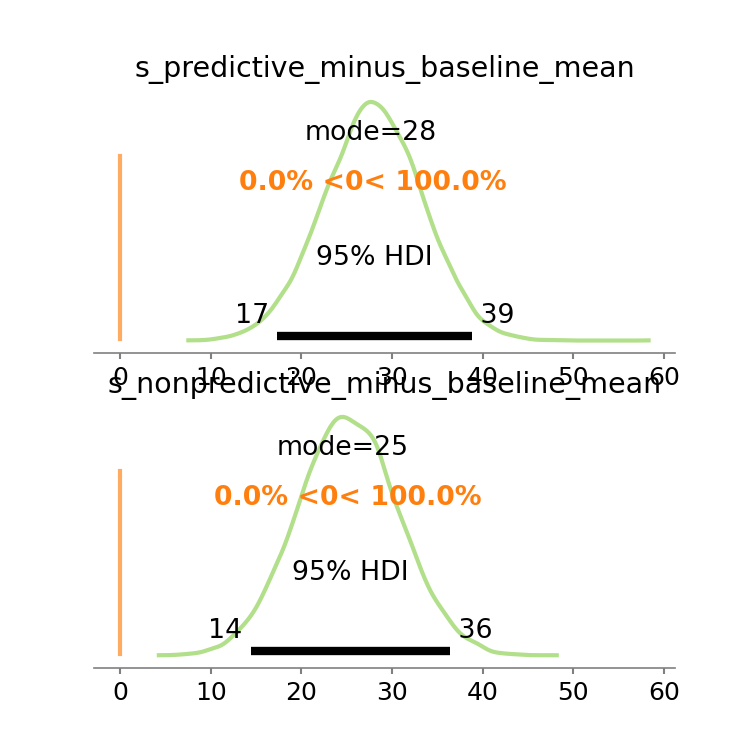

<IPython.core.display.Javascript object>


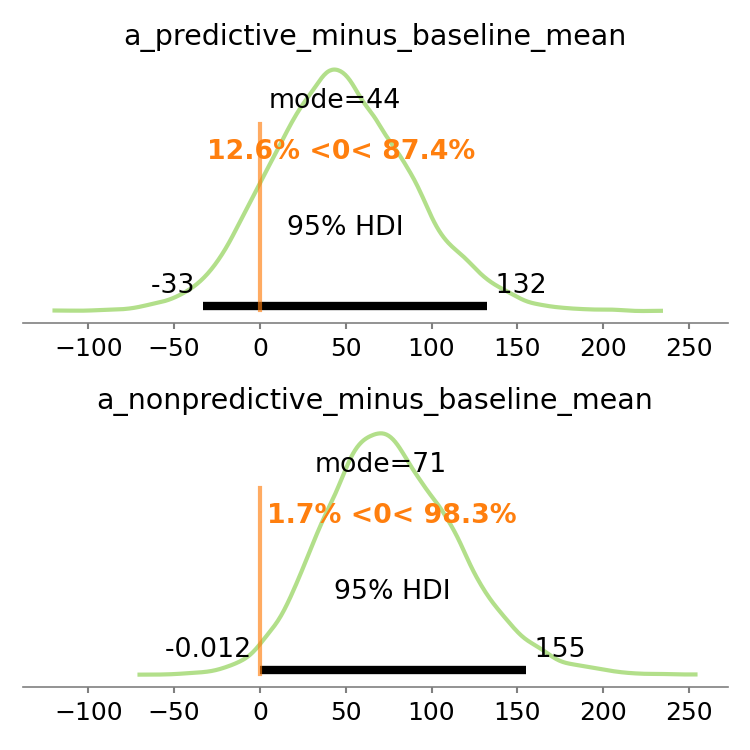

<IPython.core.display.Javascript object>


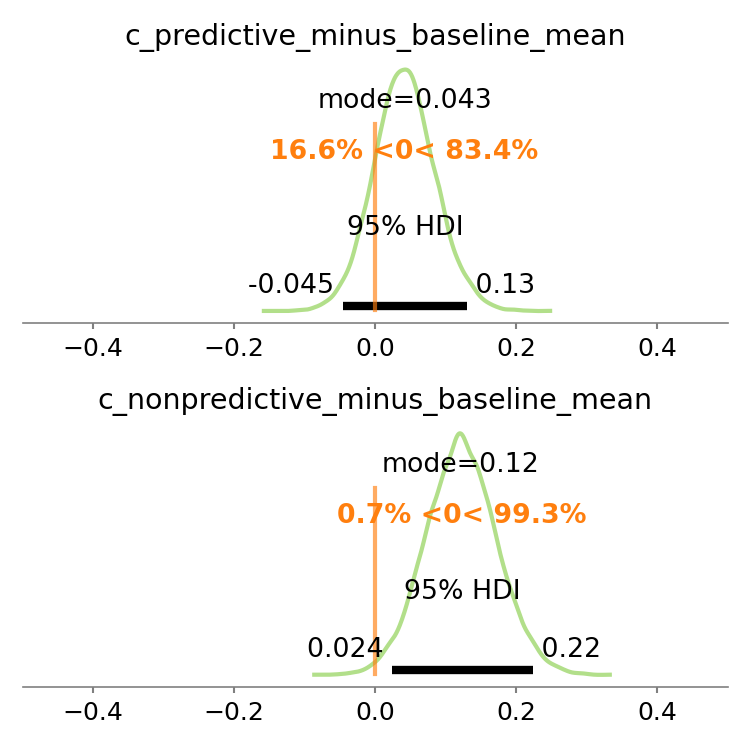

In [12]:
posterior = trace.posterior

posterior['s_predictive_minus_baseline_mean'] = (posterior.s.sel({'s_dim_1' : 2}) - posterior.s.sel({'s_dim_1' : 0}))\
                                     .mean(dim=['s_dim_0'])
posterior['s_nonpredictive_minus_baseline_mean'] = (posterior.s.sel({'s_dim_1' : 1}) - posterior.s.sel({'s_dim_1' : 0}))\
                                     .mean(dim=['s_dim_0'])

posterior['a_predictive_minus_baseline_mean'] = (posterior.a.sel({'a_dim_1' : 2}) - posterior.a.sel({'a_dim_1' : 0}))\
                                     .mean(dim=['a_dim_0'])
posterior['a_nonpredictive_minus_baseline_mean'] = (posterior.a.sel({'a_dim_1' : 1}) - posterior.a.sel({'a_dim_1' : 0}))\
                                     .mean(dim=['a_dim_0'])

posterior['c_predictive_minus_baseline_mean'] = (posterior.c.sel({'c_dim_1' : 2}) - posterior.c.sel({'c_dim_1' : 0}))\
                                     .mean(dim=['c_dim_0'])
posterior['c_nonpredictive_minus_baseline_mean'] = (posterior.c.sel({'c_dim_1' : 1}) - posterior.c.sel({'c_dim_1' : 0}))\
                                     .mean(dim=['c_dim_0'])

f, ax = plt.subplots(2,1, figsize=(5,5), sharex=True)
az.plot_posterior(trace,transform=lambda x: x*1000,
                  var_names=[ 's_predictive_minus_baseline_mean','s_nonpredictive_minus_baseline_mean'], point_estimate='mode',
                  hdi_prob=0.95, ref_val=0, show=True, textsize=12, linewidth=2, ax=ax,
                  color=palette[experiment][0])
plt.savefig('figures/distractor_cost_s_' + group + '.svg')

f, ax = plt.subplots(2,1, figsize=(5,5), sharex=True)
az.plot_posterior(trace,transform=lambda x: x*1000,
                  var_names=[ 'a_predictive_minus_baseline_mean','a_nonpredictive_minus_baseline_mean'], point_estimate='mode',
                  hdi_prob=0.95, ref_val=0, show=True, textsize=12, linewidth=2, ax=ax,
                  color=palette[experiment][0])

plt.tight_layout()

plt.savefig('figures/distractor_cost_a_' + group + '.svg')

f, ax = plt.subplots(2,1, figsize=(5,5), sharex=True)
az.plot_posterior(trace,
                  var_names=[ 'c_predictive_minus_baseline_mean','c_nonpredictive_minus_baseline_mean'], point_estimate='mode',
                  hdi_prob=0.95, ref_val=0, show=True, textsize=12, linewidth=2, ax=ax,
                  color=palette[experiment][0])
plt.tight_layout()
plt.xlim(-0.5, 0.5)
plt.savefig('figures/distractor_cost_c_' + group + '.svg')

### Distractor predictiveness effect for RT Starting level

<IPython.core.display.Javascript object>


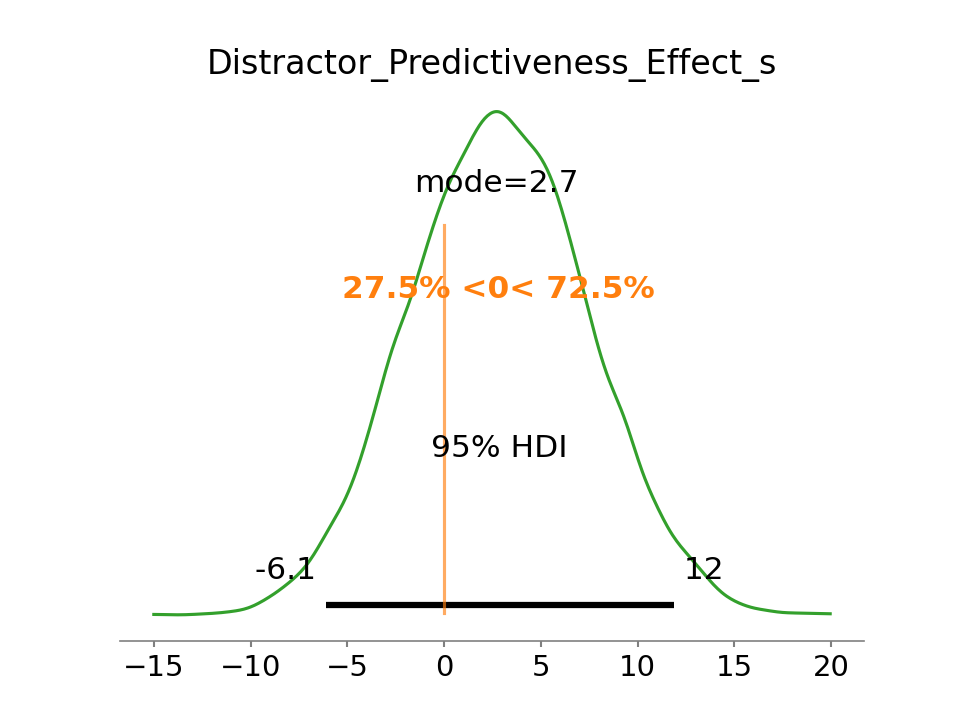

In [103]:
posterior['Distractor_Predictiveness_Effect_s'] = (
          (posterior.s.sel({'s_dim_1' : 2}) - posterior.s.sel({'s_dim_1' : 0}))\
        - (posterior.s.sel({'s_dim_1' : 1}) - posterior.s.sel({'s_dim_1' : 0}))
      ).mean(dim=['s_dim_0'])

az.plot_posterior(posterior, hdi_prob=0.95,point_estimate='mode',transform=lambda x: x*1000, var_names=['Distractor_Predictiveness_Effect_s'],ref_val = 0, color ="#33a02c")
plt.savefig('figures/Predictiveness_Effect_s_' + group + '.svg')

### Distractor predictiveness effect for RT asymptotic:

<IPython.core.display.Javascript object>


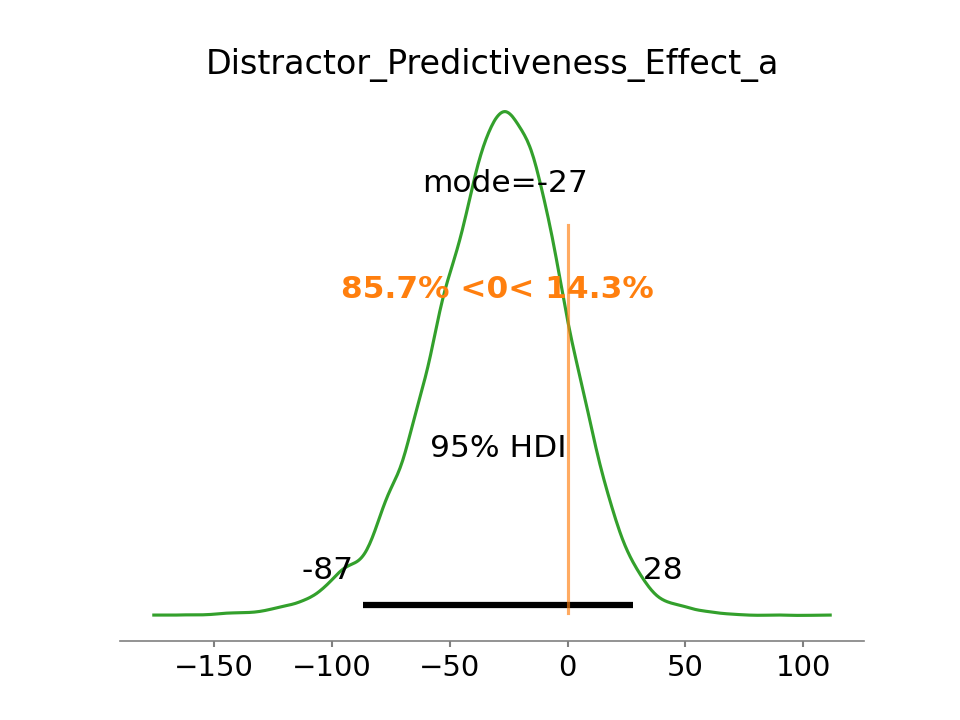

In [104]:
posterior['Distractor_Predictiveness_Effect_a'] = (
          (posterior.a.sel({'a_dim_1' : 2}) - posterior.a.sel({'a_dim_1' : 0}))\
        - (posterior.a.sel({'a_dim_1' : 1}) - posterior.a.sel({'a_dim_1' : 0}))
      ).mean(dim=['a_dim_0'])

az.plot_posterior(posterior,hdi_prob=0.95, point_estimate='mode', transform=lambda x: x*1000, var_names=['Distractor_Predictiveness_Effect_a'],ref_val = 0, color ="#33a02c")
plt.savefig('figures/Predictiveness_Effect_a_' + group + '.svg')

### Learning rate:

<IPython.core.display.Javascript object>


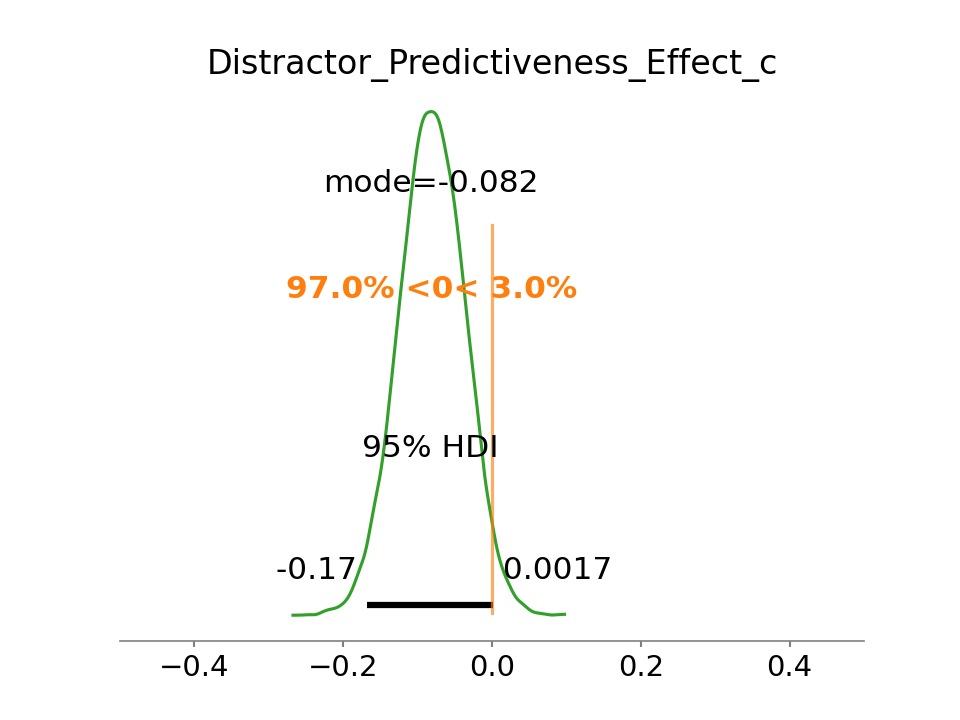

In [105]:
posterior['Distractor_Predictiveness_Effect_c'] = (
          (posterior.c.sel({'c_dim_1' : 2}) - posterior.c.sel({'c_dim_1' : 0}))\
        - (posterior.c.sel({'c_dim_1' : 1}) - posterior.c.sel({'c_dim_1' : 0}))
      ).mean(dim=['c_dim_0'])

az.plot_posterior(posterior, hdi_prob=0.95,point_estimate='mode', var_names=['Distractor_Predictiveness_Effect_c'],ref_val = 0, color ="#33a02c")
plt.xlim(-0.5, 0.5)
plt.savefig('figures/Predictiveness_Effect_c_' + group + '.svg')

### Visualizing the priors and posteriors

Since the priors for the group-level estimates are log-normal, it is difficult to assess how much information is encoded in them. The code below plots the priors and posteriors mean of these distributions on the data scale. As can be seen, the priors are essentially flat over the relevant range.

<IPython.core.display.Javascript object>


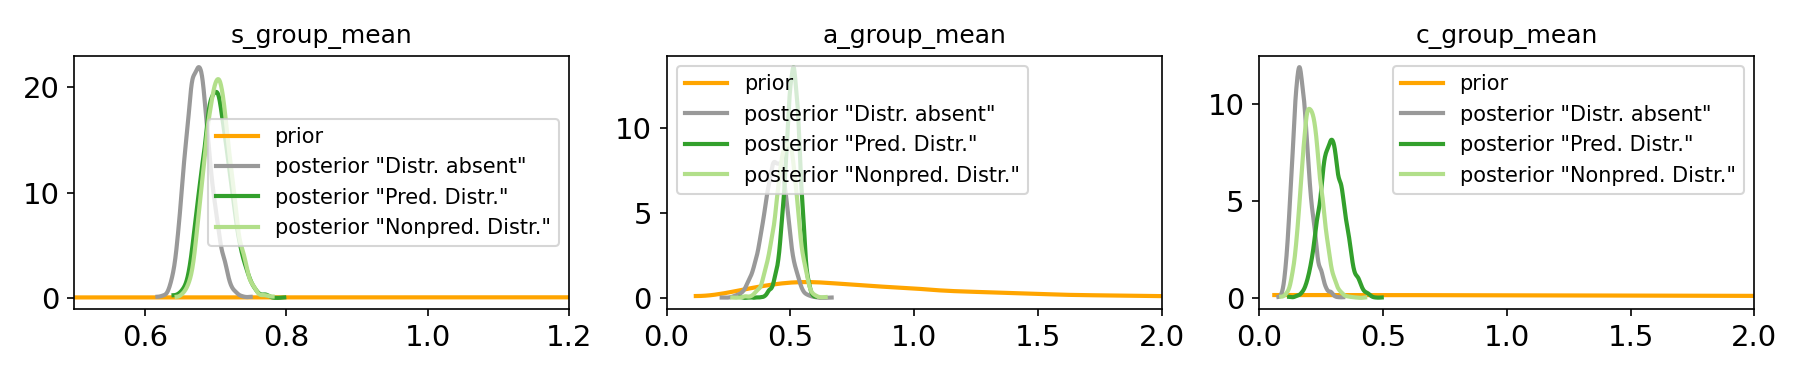

In [13]:
with model:
    prior = pm.sample_prior_predictive(samples = 10000)
    trace.extend(prior)

f, axs = plt.subplots(1,3, figsize=(12,2.5))
    
s_group_mean_prior = trace.prior['s_group_mean'][0,:,0]
az.plot_dist(s_group_mean_prior[s_group_mean_prior < 50], color='orange', ax=axs[0],  
             plot_kwargs={'lw':2, 'label':'prior'})        
az.plot_dist(trace.posterior['s_group_mean'][0,:,0],  ax=axs[0], 
             plot_kwargs={'lw':2, 'label':'posterior "Distr. absent"'}, color=palette[experiment][2])
az.plot_dist(trace.posterior['s_group_mean'][0,:,1],  ax=axs[0], 
             plot_kwargs={'lw':2, 'label':'posterior "Pred. Distr."'}, color=palette[experiment][1])
az.plot_dist(trace.posterior['s_group_mean'][0,:,2],  ax=axs[0], 
             plot_kwargs={'lw':2, 'label':'posterior "Nonpred. Distr."'},  color=palette[experiment][0])
axs[0].set_title('s_group_mean')
axs[0].legend()
axs[0].set_xlim(0.5,1.2)


a_group_mean_prior = trace.prior['a_group_mean'][0,:,0]
az.plot_dist(a_group_mean_prior[a_group_mean_prior < 10], color='orange', ax=axs[1],
             plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(trace.posterior['a_group_mean'][0,:,0], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "Distr. absent"'}, color=palette[experiment][2])    
az.plot_dist(trace.posterior['a_group_mean'][0,:,1], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "Pred. Distr."'}, color=palette[experiment][1])    
az.plot_dist(trace.posterior['a_group_mean'][0,:,2], ax=axs[1],
             plot_kwargs={'lw':2, 'label':'posterior "Nonpred. Distr."'}, color=palette[experiment][0])    
axs[1].set_title('a_group_mean')
axs[1].legend(loc='upper left')
axs[1].set_xlim(0,2)

c_group_mean_prior = trace.prior['c_group_mean'][0,:,0]
az.plot_dist(c_group_mean_prior[c_group_mean_prior < 50], color='orange', ax=axs[2],
             plot_kwargs={'lw':2, 'label':'prior'})    
az.plot_dist(trace.posterior['c_group_mean'][0,:,0], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "Distr. absent"'}, color=palette[experiment][2])    
az.plot_dist(trace.posterior['c_group_mean'][0,:,1], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "Pred. Distr."'}, color=palette[experiment][1])    
az.plot_dist(trace.posterior['c_group_mean'][0,:,2], ax=axs[2],
             plot_kwargs={'lw':2, 'label':'posterior "Nonpred. Distr."'}, color=palette[experiment][0])    
axs[2].set_title('c_group_mean')
axs[2].legend(loc='upper right')
axs[2].set_xlim(0,2)

plt.tight_layout()
plt.savefig('figures/' + experiment +'_'+ group + '_priors_vs_posteriors.svg')

### Forest plots: Baseline condition of parameter s and a

<IPython.core.display.Javascript object>


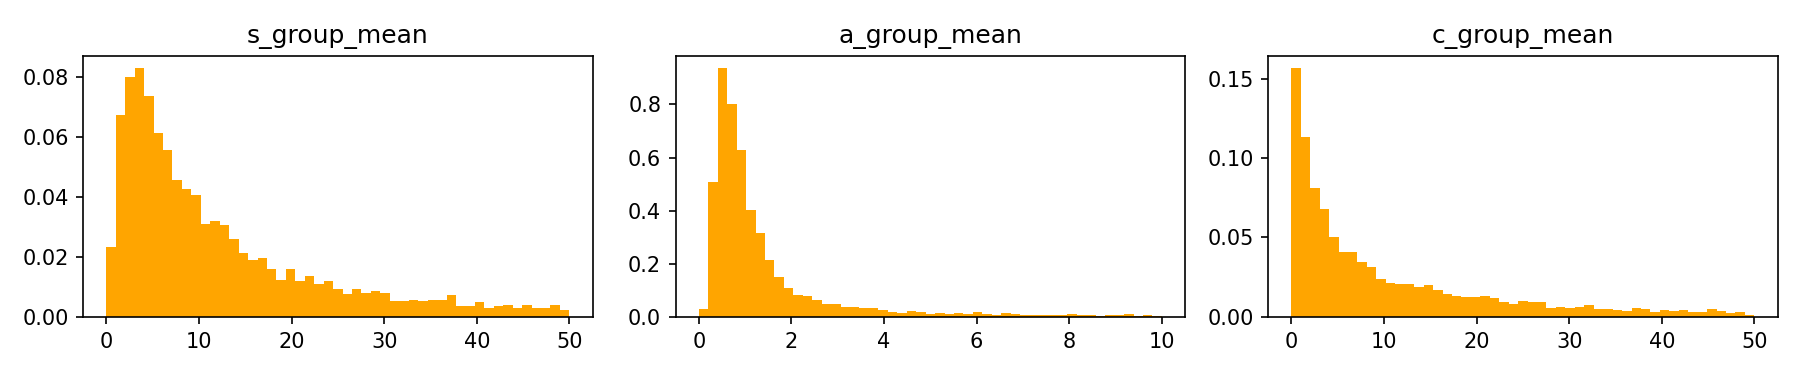

In [14]:
a = trace.prior['a_group_mean'][0,:,0]
s = trace.prior['s_group_mean'][0,:,0]
c = trace.prior['c_group_mean'][0,:,0]


f, axs = plt.subplots(1,3, figsize=(12,2.5))
axs[0].hist(s, bins=np.linspace(0,50,50), density=True, color='orange')
axs[0].set_title("s_group_mean")

axs[1].hist(a, bins=np.linspace(0,10,50), density=True, color='orange')
axs[1].set_title("a_group_mean")

axs[2].hist(c, bins=np.linspace(0,50,50), density=True, color='orange')
axs[2].set_title("c_group_mean")

plt.tight_layout()
plt.savefig('figures/' + experiment +'_'+ group + '_priors.svg')

<IPython.core.display.Javascript object>


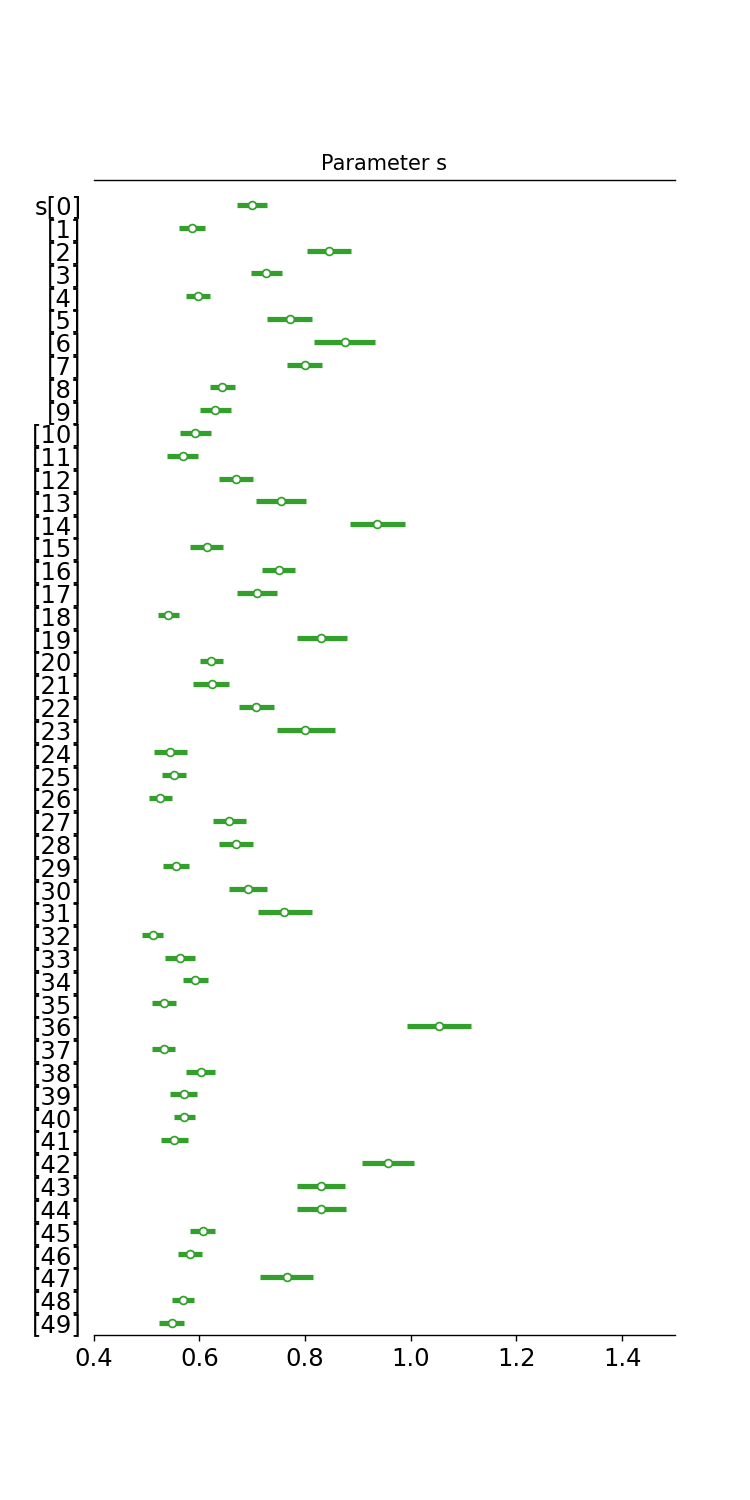

<IPython.core.display.Javascript object>


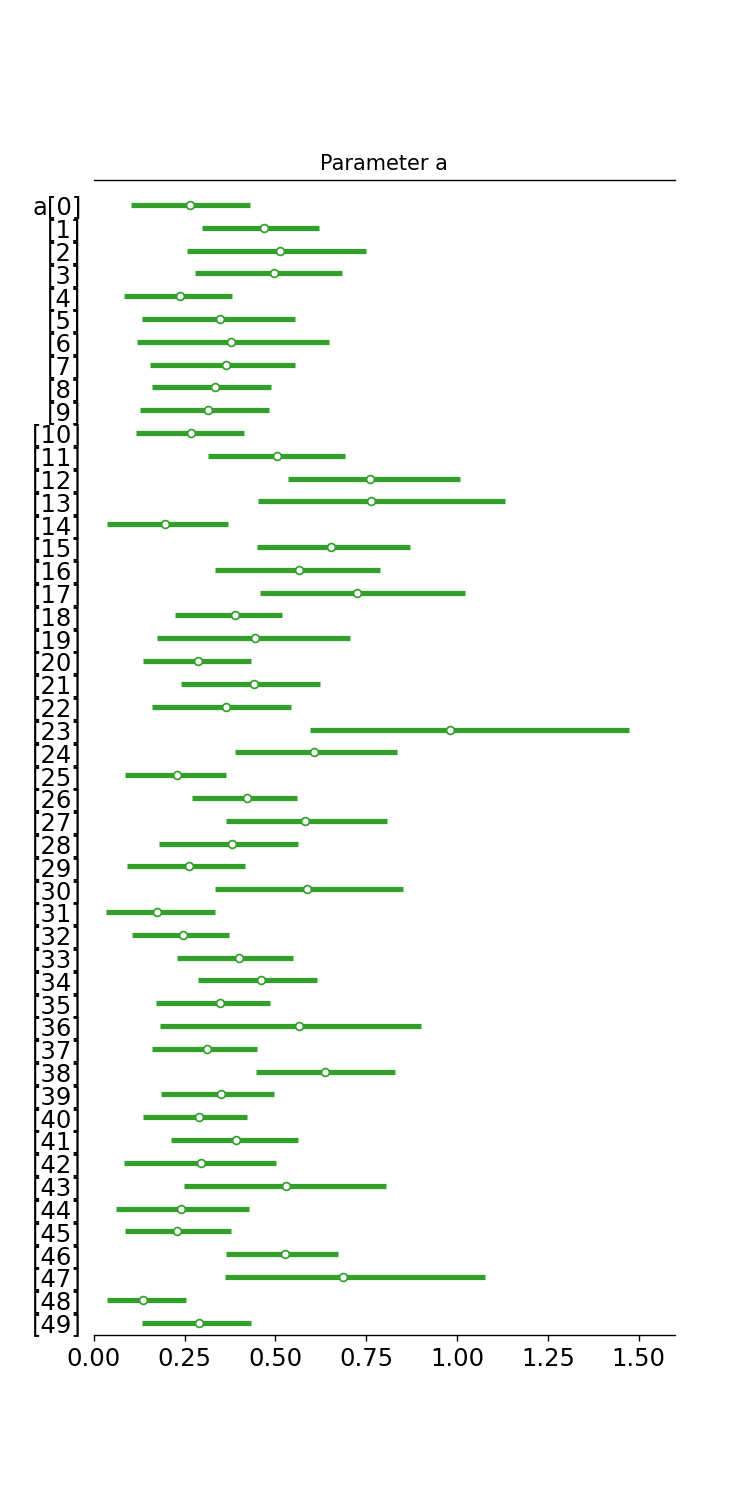

In [57]:
axs = az.plot_forest(posterior, coords={'s_dim_1' : 0}, var_names = ['s'],
                     combined=True, quartiles = False, hdi_prob=0.95, colors=palette[experiment][1],figsize=(6,12))
axs[0].set_title('Parameter s')
plt.xlim(0.4,1.5)
plt.savefig('figures/' + experiment + group + '_participant_estimates_s.svg')

axs = az.plot_forest(posterior, coords={'a_dim_1' : 0}, var_names = ['a'],
                     combined=True, quartiles = False, hdi_prob=0.95, colors=palette[experiment][1],figsize=(6,12))
axs[0].set_title('Parameter a')
plt.xlim(0,1.6)
plt.savefig('figures/' + experiment +'_'+ group + '_participant_estimates_a.svg')